# Perception acoustique puis multimodale

In [1]:
import os
import sys
from AudioMNISTLoader import AudioDataset
from ShowAudioFile import main
import random
import torch
import torchaudio
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import Audio
from matplotlib.patches import Rectangle
from torchaudio.utils import download_asset
import torchaudio.functional as F
import torchaudio.transforms as T
import librosa
import pandas as pd
from torch.utils.data import Dataset
print(torch.__version__)
print(torchaudio.__version__)

2.7.0+cu128
2.7.0+cu128


c:\Users\kopno\Desktop\TP-S6-R6\.venv\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


**Téléchargez « AudioMNIST.zip ». Regardez et écoutez quelques exemples du répertoire
« recordings ». Vous y trouverez des fichiers dont le nom est composé du chiffre à énoncer
de 0 à 9, suivi du nom du locuteur, suivi de numéro de la répétition (de 0 à 50). Nous
limitons Audio MNIST à 3000 fichiers pour ce TP**

In [2]:
files = os.listdir('recordings')
num_files = len(files)
print(f"Nombre de fichiers audio : {num_files}")

Nombre de fichiers audio : 3000


**Utilisez  le  script  « ShowAudioFile.py » pour visualiser quelques fichiers. L’axe des y 
représente les fréquences sur le spectrogram. D’après ce que nous avons vu en cours, quelles 
sont  les  fréquences  représentées  sur  ce  graphe ?  Le script utilise (comme l’auteur) le 
MelSpectrogram. A quoi cela correspond-t-il ?**

In [3]:
random.seed(42)
selected_files = random.sample(files, 2)

Read 'recordings\8_theo_26.wav' with option spectrogram=True


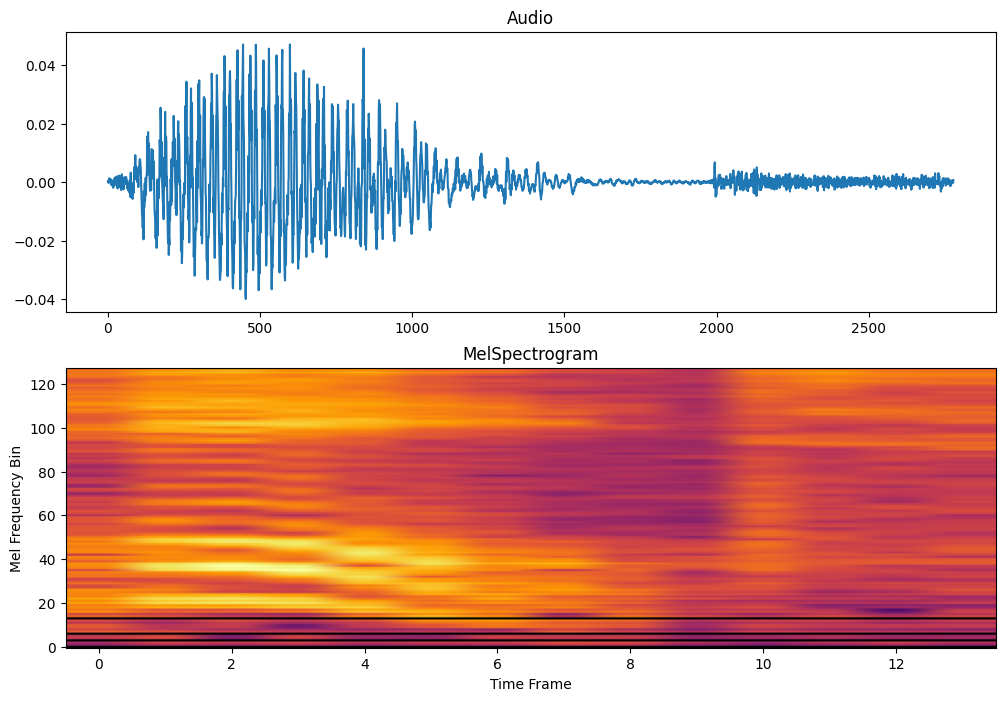

Sample rate: 8000 Hz
Waveform shape: torch.Size([1, 2779])
Spectrogram shape: torch.Size([1, 128, 14])
Duration: 0.35 seconds
Read 'recordings\1_nicolas_14.wav' with option spectrogram=True


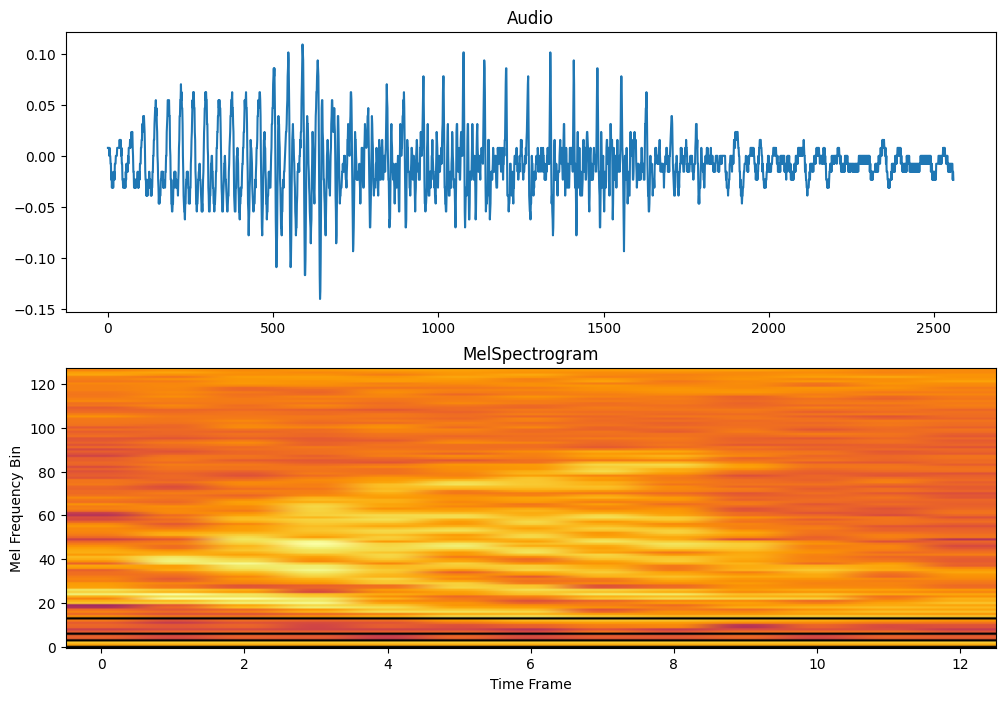

Sample rate: 8000 Hz
Waveform shape: torch.Size([1, 2560])
Spectrogram shape: torch.Size([1, 128, 13])
Duration: 0.32 seconds


In [4]:
for file in selected_files:
    sys.argv = [
        'script.py', 
        os.path.join('recordings', file), 
        '--spectrogram'
    ]
    main()

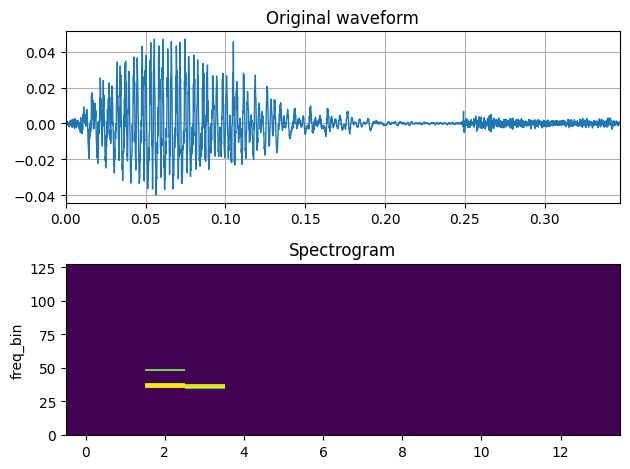

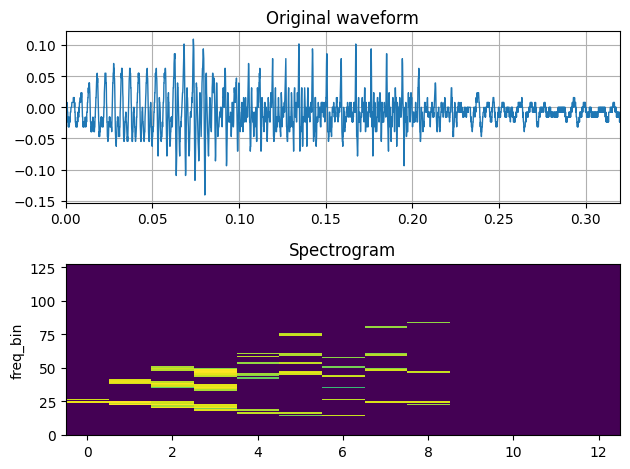

In [5]:
torch.random.manual_seed(0)

SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")

ToSpectrogram = torchaudio.transforms.MelSpectrogram()
ToDB = torchaudio.transforms.AmplitudeToDB()

def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")

# Load audio
SPEECH_WAVEFORM, SAMPLE_RATE = torchaudio.load(SAMPLE_SPEECH)

# Define transform
spectrogram = T.Spectrogram(n_fft=512)

# Perform transform
spec = spectrogram(SPEECH_WAVEFORM)
# Loop through the selected files and visualize them
for file in selected_files:
    file_path = os.path.join('recordings', file)
    waveform, sample_rate = torchaudio.load(file_path)
    spectrogram = ToSpectrogram(waveform)
    # spectrogram = T.Spectrogram(n_fft=512)(waveform)
    spec = ToDB(spectrogram)
    # spec = librosa.power_to_db(spectrogram)
    
    fig, axs = plt.subplots(2, 1)
    plot_waveform(waveform, sample_rate, title="Original waveform", ax=axs[0])
    plot_spectrogram(spec[0], title="Spectrogram", ax=axs[1])
    fig.tight_layout()
    plt.show()

**Les scripts proposés par l’auteur sur  Kaggle  proposent  de  séparer  le  corpus  en  train/test 
automatiquement  (bloc  1  du  jupyter  notebook  en  ligne).  Je  vous  propose  une  version  du 
script adapté à notre organisation des données : « SplitTrainTest_original.py ». Exécutez ce 
script,  regardez  le  contenu  des  fichiers  csv  générés.  Par  rapport  à  ce  que  nous  avons  vu 
précédemment dans ce TP, que pouvez-vous dire de cette séparation en train/test ?**

Contrairement a ce qu'on a vue précédemment, le script découpe le jeux de données en 2 subset représentant 75% des données pour l'entrainement et 25% des données pour les tests. (et on pas 80/20)

La méthode de séparation utilise un mélange aléatoire de l'ensemble des données avant la séparation, cela permet d'avoir des jeux de données équilibré, représentant chaque modalités cibles relativement également. 

In [6]:
# Execute the script
!python SplitTrainTest_original.py

In [7]:
class AudioDatasetSpectrogram(Dataset):
    def __init__(self, annotations_file, ToSpectrogram, ToDB):
        self.annotations = pd.read_csv(annotations_file, header=None, 
                                       names=['Path', 'Label'], delimiter=',')
        self.ToSpectrogram = ToSpectrogram
        self.ToDB = ToDB
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        audio_padded = torch.zeros((1, 48000))
        audio, _ = torchaudio.load(self.annotations.iloc[index, 0])
        audio_padded[0, :audio.shape[1]] = audio[0]
        label = self.annotations.iloc[index, 1]
        spectrogram = self.ToSpectrogram(audio_padded)
        spectrogram = self.ToDB(spectrogram)
        return spectrogram, label

In [8]:
# Load the CSV files
test_df = pd.read_csv('./test_audioMNIST.csv', names=['file_path', 'label'])
train_df = pd.read_csv('./train_audioMNIST.csv', names=['file_path', 'label'])

# Display the first few rows of each dataframe
print("Test DataFrame:")
display(test_df.head())

print("\nTrain DataFrame:")
display(train_df.head())

# Get the number of individuals in each dataframe
test_df['speaker'] = test_df.iloc[:, 0].apply(lambda x: x.split('_')[1])
train_df['speaker'] = train_df.iloc[:, 0].apply(lambda x: x.split('_')[1])

# ================================================================

num_individuals_test = test_df['speaker'].nunique()
num_individuals_train = train_df['speaker'].nunique()

print(f"\nNumber of individuals in test set: {num_individuals_test}")
print(f"Number of individuals in train set: {num_individuals_train}")

# ================================================================

# Get the number of samples in each dataframe
num_samples_test = test_df.shape[0]
num_samples_train = train_df.shape[0]

print(f"\nNumber of samples in test set: {num_samples_test}")
print(f"Number of samples in train set: {num_samples_train}")

# ================================================================

# Count occurrences of each number in the test set
test_counts = test_df.iloc[:, 1].value_counts()
test_proportions = test_counts / num_samples_test
print("Test set counts and proportions:")
display(pd.DataFrame({'Count': test_counts, 'Proportion': test_proportions}))

# Count occurrences of each number in the train set
train_counts = train_df.iloc[:, 1].value_counts()
train_proportions = train_counts / num_samples_train
print("\nTrain set counts and proportions:")
display(pd.DataFrame({'Count': train_counts, 'Proportion': train_proportions}))

# Combine both dataframes to count occurrences in the full dataset
full_df = pd.concat([test_df, train_df], ignore_index=True)
num_samples_full = full_df.shape[0]
full_counts = full_df.iloc[:, 1].value_counts()
full_proportions = full_counts / num_samples_full
print("\nFull dataset counts and proportions:")
display(pd.DataFrame({'Count': full_counts, 'Proportion': full_proportions}))

Test DataFrame:


,file_path,label
0,recordings/8_lucas_45.wav,8
1,recordings/0_theo_26.wav,0
2,recordings/3_yweweler_2.wav,3
3,recordings/6_lucas_1.wav,6
4,recordings/2_george_26.wav,2



Train DataFrame:


,file_path,label
0,recordings/7_theo_6.wav,7
1,recordings/5_theo_3.wav,5
2,recordings/4_yweweler_8.wav,4
3,recordings/0_theo_22.wav,0
4,recordings/1_yweweler_1.wav,1



Number of individuals in test set: 6
Number of individuals in train set: 6

Number of samples in test set: 750
Number of samples in train set: 2250
Test set counts and proportions:


,Count,Proportion
label,,
1,82,0.109333
9,80,0.106667
2,78,0.104000
8,76,0.101333
4,76,0.101333
6,74,0.098667
7,73,0.097333
5,72,0.096000
0,70,0.093333



Train set counts and proportions:


,Count,Proportion
label,,
3,231,0.102667
0,230,0.102222
5,228,0.101333
7,227,0.100889
6,226,0.100444
4,224,0.099556
8,224,0.099556
2,222,0.098667
9,220,0.097778



Full dataset counts and proportions:


,Count,Proportion
label,,
8,300,0.1
0,300,0.1
3,300,0.1
6,300,0.1
2,300,0.1
9,300,0.1
5,300,0.1
7,300,0.1
1,300,0.1


**Nous  allons  étudier  certains  blocs  du  jupyter  Notebook.  Les  blocs  2  à  9  servent  au 
chargement  des  données.  Le  bloc  10  sert  à  normaliser  les  données  en  utilisant un 
moyennage. Expliquez ce que font les blocs de 11 à 15. Quel modèle décrivent-ils ? (https://www.kaggle.com/code/jokekling/pytorch-study-audio)**

### Block 11
Le block 11 définis une classe CNN (Convolutional Neural Network), contenant une initalisation et une méthode : 
- L'initialisation définis une séquence d'opération comme l'algorithme ConvNet, utilisant des méthode hérité de `nn/Module`. Elle définis l'architecture du réseau de neurones, ces couches : 
    1) Convolution 2D, avec 1 canal d'entrée, 10 de sortie et un noyaux de taille 7x7 et un pas de 3. Cette couche produit 10 feature maps pour chaque données d'entrée, le filtre faisant cela est de taille 7x7 permettant de detecter des oattern dans les données.  
    2) Fonction d'activation ReLU, appliqué a la 1er couche. (Introduit de la non linéarité)
    3) Convolution 2D, avec 10 canal d'entrée, 10 de sortie et un noyaux de taille 5x5 et un pas de 2. La couche prend en entrée les 10 fetaures maps de la couche précédente, le filtre appliqué au feature maps est de taille 5x5, appliqué a chaque feature map il effectue des convolutions sur les données. Le pas et le kernel diminué permettent de diminuer la taille de la sortie de la 2e couche comparé a la 1er. 
    4) Fonction d'activation ReLU, appliqué a la 2e couche. 
    5) Applatissement des données (couche de neurones) en un vecteur 1D. 
    6) Applique une fonction affine linéaire au données, prend en entrée un vecteur de grande taille (38*19*10), et donne un vecteur de taille 10 en sortie. 
- La méthode forward permet de passer des données dans le reseaux définis précédemment. On passe une données X dans le réseau et on sort les logits, score brut (avant f() d'activation) pour chaque classe prédite.

### Block 12
Le block 12 créer une model a partir de la classe CNN, ce modele est transferet sur un dispositif qui sera la GPU si il y en a, et le CPU sinon. 

### Block 13
Le block 13 initialise la fonction de perte d'entropie de pytorch. Elle permet de mesure les écarts entre prédictions du modele et vrais étiquettes des données, la Loss. Cela permet d'évaluer la performance du modele créé. Plus la Loss est faible, plus le modele est bon. 

Ensuite le block contient un optimiseur de modele via un gradient. Il permet d'ajuster les poids du modele pour minimiser la Loss. Les parametres du gradients sont : un taux d'aprentissage a 0.001 (taille des maj de poids), et un momentum de 0.9 (aide a converger vite). 

### Block 14
Ce block définis 2 fonctions : 
- La fonction train, utilise le modele CNN prédéfinis, l'optimiseur, la fonction permettant de calculer la Loss, et des données d'entrées. 
La fonction, pour des lots des données : 
    1. Charge les données (dans le format adapté au device (GPU ou CPU)) et normalise, 
    2. Utilise le modele CNN en mode entrainement pour activer le calculs des gradients, 
    3. Ensuite les opérations "Forward Pass" ont lieu : récupere les prédictions de labels fais par le modele, calcul la loss, 
    4. Met a jour les indicateurs globaux le la loss total et du nombre de prédiction correctes, 
    5. Enfin à lieu le "Backward Pass", on utilise la backpropagation via l'optimiseur gradient (reset du gradient, calculs des pertes pour les parametres, mise a jour des parametres du gradient). 
    6. La fonction renvoie la perte moyenne et le score du modele (précision). 

- La fonction Test, utilise le modele CNN, et la fonction de calcul de la Loss. 
La fonction, par lots : 
    1. Charge les données (dans le format adapté au device (GPU ou CPU)) et normalise, 
    2. Utilise le modele CNN en mode évaluation sans activer le calculs des gradients, 
    3. Ensuite on fais uniquement une opération "Forward Pass", on utilise le model et recupere les prédictions, 
    4. Calculons la Loss de ce modele mettons a jours les indicateurs globaux.
    5. Enfin, la fonction renvoie la perte moyenne et le score du modele (précision). 

### Block 15
Dans ce block on utilise tout les éléments et fonctions définis précédemments. Pour 30 epochs, on entraine et test le modele, en ajoutant tout les indicateurs de performance (loss et score de précision) a des listes pour les conserver. 

### Quel modèle ?

Les blocs 11 à 15 décrivent un modèle de réseau de neurones convolutif (CNN) pour la classification d'images et de spectrogrammes audio. Le modèle est entraîné à l'aide de PyTorch, avec des fonctions de perte et des optimisateurs pour ajuster les poids du réseau. Le processus d'entraînement et de test est itératif, avec des évaluations de la performance à chaque époque pour suivre la précision et la perte du modèle.

**Le  bloc  16  présente  les  losses  d’apprentissage  et  de  test  associées  avec  le  score  de 
reconnaissance des chiffres (de 0 à 100%). Commentez ce graphique.**

Nous observons sur chaque graphique une stabilisation des scores et Loss avec l'augmentation du nombre d'epochs. 

1) En observant les scores, nous observons qu'ils atteigne tres rapidement un niveau proche de 1. Cela signifie que la précision de la labéllisation est 

2) Le score de reconnaissance des chiffres en fonction des itérations
    - La courbe bleue (train) montre que l'accuracy atteint un plateau proche de 100 %, ce qui suggère un apprentissage quasi parfait sur l'ensemble d'entraînement.
    - La courbe orange (test) monte initialement, puis se stabilise à une valeur inférieure à 100 %, indiquant une généralisation correcte mais possiblement un overfitting si l'écart avec l'entraînement est trop grand.

3) La courbe de loss (perte) en fonction des itérations (epochs) : 
    - La courbe bleue représente la loss d'entraînement, qui diminue rapidement et se stabilise à une valeur très basse.
    - La courbe orange représente la loss de test, qui diminue également mais reste plus élevée que celle d'entraînement. Cela indique un certain écart entre les performances sur l'entraînement et le test.

**Nous souhaiterions utiliser les  corpus MNIST  et  Audio MNIST pour réaliser un système 
multimodal de reconnaissance de caractère où l’on écrirait et énoncerait le chiffre en même 
temps, le but étant de palier les problèmes de reconnaissance des chiffres écrits et énoncés 
séparément  pour  se  rapprocher  d’une  performance  à  100%.  Comment  pourriez-vous 
procéder en utilisant le projet de Kaggle ? Décrivez toutes les étapes.**

# Système Multimodal de Reconnaissance de Caractères avec MNIST et AudioMNIST

## 1. Préparation des Données
### MNIST (Images)
- Charger le dataset MNIST via `torchvision`.
- Normaliser les images et diviser en ensembles d'entraînement et de test.

### AudioMNIST (Audio)
- Charger le dataset AudioMNIST en utilisant les fichiers CSV fournis.
- Prétraiter les fichiers audio :
  - Uniformiser la durée des signaux (remplissage ou tronquage).
  - Convertir les signaux en MelSpectrogram pour obtenir une représentation en fréquence.
  - Appliquer une transformation logarithmique pour une meilleure robustesse.
- Diviser les données en ensembles d'entraînement et de test.

## 2. Extraction des Caractéristiques
- Pour MNIST, les pixels des images constituent les features.
- Pour AudioMNIST, extraire des caractéristiques à partir des MelSpectrograms.

## 3. Conception du Modèle
### Modèles Indépendants
- **Modèle Image (CNN)** : Convolutional Neural Network (CNN) pour classifier les images MNIST.
- **Modèle Audio (CNN/RNN)** : CNN ou RNN (LSTM, GRU) pour classifier les spectrogrammes AudioMNIST.

### Fusion Multimodale
- Combinaison des features des deux modèles.
- Plusieurs stratégies de fusion possibles :
    1. **Fusion précoce** : concaténation des caractéristiques brutes.
         - Les images MNIST et les spectrogrammes audio sont traités comme des entrées conjointes.
         - Avantage : permet au modèle d'apprendre des corrélations à bas niveau entre les modalités.
         - Défi : nécessite d'harmoniser les dimensions des différentes modalités (images et signaux audio de chiffres).
    
    2. **Fusion intermédiaire** : combinaison des caractéristiques après traitement partiel.
         - Les CNNs extraient séparément les caractéristiques de chaque modalité, puis ces caractéristiques sont fusionnées.
         - Avantage : permet d'extraire des représentations spécifiques à chaque modalité avant fusion.
         - Implémentation : concaténation des vecteurs de caractéristiques ou utilisation d'une couche d'attention (qui attribue des poids a certaines parties des données).
    
    3. **Fusion tardive** : combinaison des prédictions finales de chaque modèle.
         - Chaque modèle produit sa propre prédiction, puis ces prédictions sont combinées.
         - Méthodes : moyenne pondérée, vote majoritaire ou modèle d'apprentissage supplémentaire.
         - Avantage : robustesse accrue si une modalité est défaillante ou bruitée.

- Architecture du modèle fusionné :
    - Encodeurs spécifiques à chaque modalité (CNN pour images, CNN/RNN pour audio)
    - Mécanisme d'attention pour pondérer l'importance de chaque modalité
    - Couches fully connected finales pour la classification des 10 chiffres (0-9)

## 4. Entraînement
- Entraîner le modèle image sur MNIST.
- Entraîner le modèle audio sur AudioMNIST.
- Entraîner le modèle fusionné sur la combinaison des données.
- Utiliser une fonction de perte adaptée (ex. Cross-Entropy Loss).
- Implémenter un mécanisme d'attention pour pondérer l'importance de chaque modalité.

## 5. Évaluation
- Tester la performance des modèles individuels.
- Tester la performance du modèle fusionné.
- Comparer les résultats et identifier les cas où une modalité est plus fiable que l'autre.

## 6. Optimisation
- Expérimenter avec différentes architectures et hyperparamètres.
- Appliquer des techniques d'augmentation de données.
- Ajuster la stratégie de fusion pour améliorer les performances.

## 7. Déploiement
- Exporter le modèle final.
- Tester avec des entrées utilisateur pour valider la robustesse.

Cette approche permet d'exploiter la complémentarité entre l'image et l'audio afin d'améliorer la reconnaissance des chiffres et de se rapprocher d'une performance optimale.


---
---

## Déroulé brute

1. Préparation des données
   1. Télécharger les données MNIST via torchvision, image de chiffre écrit, et enregistrements audios des chiffres prononcés, AudioMNIST
2. Prétraitement des données
   1. Pour les images MNIST, normalisation et redimensionnement (si nécessaire)
   2. Conversions des enregistrement audio en fichier Tensors/torchaudio
   3. Découpage des données en subset d'apprentissage et de tests
   4. Standardisation des longueurs de signaux audios (complétion par un signal vide, ou coupe de l'extrait selon que le signal d'origine sois trop court/long)
   5. Transformation du signal audio en MelSpectrogram audio (représentation en fréquence)
   6. Transformation des spectres en échelles décibels (représentation logarithlique des intensités)
3. Début de la construction du mdoele
   1. Initialisation de 2 Convolutional Neural Network, CNN, un pour les images, un autres pour les audios
   2. Fusions en une couche des 2 CNN (images et audios)

   Stratégies de fusion :

   Fusion précoce : concaténation des caractéristiques brutes
   Fusion intermédiaire : combinaison des caractéristiques après traitement partiel
   Fusion tardive : combinaison des prédictions individuelles de chaque modalité
   Tester différentes stratégies pour déterminer la plus efficace

   3. Entraînement du modèle :

   Utiliser une fonction de perte adaptée (comme l'entropie croisée)
   Implémenter un mécanisme d'attention pour donner plus de poids à la modalité la plus fiable selon le contexte
   Appliquer des techniques d'augmentation de données pour améliorer la robustesse


   4. Évaluation et optimisation :

   Tester le modèle sur différentes configurations :

   Performance sur chaque modalité séparément
   Performance du modèle combiné


   Analyser les cas où une modalité est plus fiable que l'autre
   Implémenter une stratégie de décision qui privilégie la modalité la plus fiable en cas de désaccord


Exercice réalisé par Dorian RELAVE ([Legolaswash](https://github.com/Legolaswash))